In [84]:
import pandas as pd
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from UKMovementSensing import hsmm

In [86]:
states_path_model = '/media/sf_VBox_Shared/London/raw/first5/datawithstates/model_rolacc_4states.pkl/'

In [87]:
# Import data with states
filenames = os.listdir(states_path_model)
filenames = [fn for fn in filenames if os.path.isfile(os.path.join(states_path_model,fn))]
datasets = [pd.read_csv(os.path.join(states_path_model,fn), encoding='utf-8') for fn in filenames]
print(len(datasets))

11


In [88]:
example_index = 0
data = datasets[example_index]
hidden_states = data['state']

In [89]:
data.columns

Index([u'timestamp', u'acceleration', u'EN', u'anglex', u'angley', u'anglez',
       u'roll_med_acc_x', u'roll_med_acc_y', u'roll_med_acc_z',
       u'dev_roll_med_acc_x', u'dev_roll_med_acc_y', u'dev_roll_med_acc_z',
       u'invalid', u'filename', u'Slot', u'act', u'act_label', u'start_time',
       u'subset', u'switched_pos', u'state'],
      dtype='object')

In [90]:
colormap, cmap = hsmm.get_color_map(data.state.nunique()+1)

In [91]:
def plot_states_and_var(data, hidden_states, cmap=None, columns=None, by='Activity'):
    """
    Make  a plot of the data and the states

    Parameters
    ----------
    data : pandas DataFrame
        Data to plot
    hidden_states: iteretable
        the hidden states corresponding to the timesteps
    columns : list, optional
        Which columns to plot
    by : str
        The column to group on
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    if columns is None:
        columns = data.columns
    for act in set(data[by]):
        for col in columns:
            dfa = data[col].copy()
            dfa[data[by] != act] = 0
            dfa.plot(label=str(col) + ' - ' + str(act), ax=ax)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3)
    if cmap is None:
        num_states = max(hidden_states) + 1
        colormap, cmap = get_color_map(num_states)
    scale = np.array(data[columns]).max()
    sca = plt.scatter(
        data.index,
        np.ones_like(hidden_states) * scale,
        c=hidden_states,
        cmap=cmap,
        edgecolors='none')
    plt.colorbar(
        sca,
        ticks=np.arange(np.min(hidden_states),
                        np.max(hidden_states) + 1))


In [92]:
columns=['acceleration']
by='act'
df = data[columns]
stateseq = np.array(hidden_states)
actseq = np.array(data[by])

In [104]:
from pyhsmm.util.general import rle
stateseq_norep, durations = rle(stateseq)
datamin, datamax = np.array(df).min(), np.array(df).max()
x, y = np.hstack((0,durations.cumsum())), np.array([datamin,datamax])
C = np.atleast_2d([colormap[state] for state in stateseq_norep])

In [105]:
maxstate = data.state.nunique()+1
C = np.array([[float(state)/maxstate] for state in stateseq_norep]).transpose()
C.shape

(1, 132)

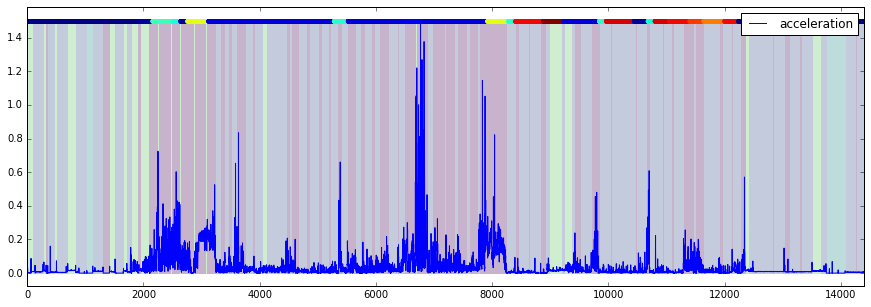

In [109]:
fig, ax = plt.subplots(figsize=(15, 5))
#ax.set_ylim((datamin,datamax))
ax.pcolorfast(x,y,C,vmin=0,vmax=1,alpha=0.3, cmap=cmap)
data[columns].plot(ax=ax)
ax.set_xlim((0,len(hidden_states)))
sca = ax.scatter(
        data.index,
        np.ones_like(hidden_states) * datamax,
        c=actseq,
        #cmap=cmap,
        edgecolors='none'
        )